# Carbon emissions tracking

This notebook applies the excellent [CodeCarbon](https://github.com/mlco2/codecarbon) project for tracking
the carbon emissions of machine learning computation (in equivalent kg of CO2) as a Weave Op.
There are many possible scenarios for compute tracking:
* online vs offline
* local compute vs cloud compute
* what system metrics are available in W&B for past runs (depends on SDK version)

The base case I address here is offline non-cloud compute (i.e. experiments I ran on a GPU box and logged to W&B).
This may also work for offline cloud compute (runs with system metrics logged from a Google Colab)—TBD, as these runs often log much fewer datapoints.

## 0. Install dependencies & define utils

Currently define a custom processor for each project since we may be interested in different fields.
Ideally this is all easy to do in Weave and not through the wandb API.
Right now there are lots of edge cases where Weave fails on wandb API data because of
undefined fields/many possible types/missing fields/etc.

In [1]:
!pip install codecarbon -qqq
from codecarbon.viz import data

import wandb
import pandas as pd
import weave

In [2]:
# utils: get runs from a project: [entity/project name]
# some good examples included in this notebook from my projects (entity=stacey)
# - climate_bert
# - mendeleev
# - deep-drive
# NOTE: runs are not iterable!! you need to make a new list first
# iterable_runs = [r for i, r in enumerate(runs) if i < 10]
def get_runs(project_name):
    api = wandb.Api()
    return api.runs(project_name)

In [32]:
# iterate over all the runs, extract all relevant fields into a list,
# compute emissions, return list to be made into a table
# TODO: refactor
def parse_climatebert_runs(runs, full_project_path):
    t = []
    for r in runs:
        try:

            if "eval/loss" in r.summary:
                loss = r.summary["eval/loss"]
                run_type = "train"
            else: 
                loss = -1.0
                run_type = "eval"
            full_path = "/".join([full_project_path, r.id])
            em = past_run_emissions(full_path)
            t.append({"run_name" : r.name, "eval/loss" : loss, "run_type" : run_type, "emissions" : em})
        except:
            pass
    return t

def parse_deepdrive_runs(runs, full_project_path):
    t = []
    for r in runs:
        try:
            acc = r.summary["acc"]
            iou = r.summary["iou"]
            encoder = r.config["encoder"]
            full_path = "/".join([full_project_path, r.id])
            em = past_run_emissions(full_path)
            t.append({"run_id" : r.id, "acc" : acc, "iou" : iou, "encoder" : encoder, "emissions" : em})
        except:
            pass
    return t

def parse_mendeleev_runs(runs, full_project_path):
    t = []
    for r in runs:
        try:
            loss = r.summary["loss"]
            acc = r.summary["accuracy"]
            val_acc = r.summary["val_accuracy"]
            fc_size = r.config["fc_size"]
            num_train = r.config["num_train"]
            full_path = "/".join([full_project_path, r.id])
            em = past_run_emissions(full_path)
            t.append({"run_name" : r.name, "loss" : loss, "acc": acc, "val_acc" : val_acc, 
                      "fc_size": fc_size, "num_train" : num_train, "emissions" : em})
        except:
            pass
    return t

## 1. Compute emissions for a wandb run

Fair amount of approximation involved.

In [31]:
def past_run_emissions(wandb_full_run_path, units="kg_co2"):
    """Get system metrics for this run from the wandb API. See if multiple GPUs
       were active. Add up their power watts and roughly multiply out to get the
       total kWh for this run. Calculations are rough because we get a datapoint
       every 2 seconds from the SDK which is averaged over 30 seconds..?
       Return -1 if any part of this fails.
       Note that a lot of the results will be 0 (if the run is too short, from an
       older SDK version, possibly if it ran in a notebook, etc)
    """
    # fetch run from W&B
    api = wandb.Api()
    try:
        run = api.run(wandb_full_run_path)
    except:
        print("Failed to fetch run from wandb")
        return -1
    # fetch system metrics
    try:
        system_metrics = run.history(stream="events")
    except:
        print("Failed to fetch system metrics for run")
        return -1
    system_metrics.to_csv("sys_metrics.csv")
    
    # TODO: threshold on data point count for sys metrics—what if it's a colab run with a single point?
    # TODO: check _wandb.cli_version >= 0.8.30, 
    # handle other versions:
    # - <= 0.8.19 doesn't track powerWatts
    # - 0.8.21 doesn't clarify which GPU is in use
    # - 0.8.25 tracks powerWatts, but these appear to be percentages only...
    sys_metrics_df = pd.read_csv("sys_metrics.csv")
    cols = sys_metrics_df.columns
    watts_cols = [c for c in cols if "powerWatts" in c]

    # process ran on GPU N such that we have a column for system.gpu.process.N.powerWatts
    if len(watts_cols) > 1:
        #print("columns: ", watts_cols, run.id)
        watts_cols = [c for c in watts_cols if "system.gpu.process" in c]
        
    # add up across GPUs
    total_watts = 0.0
    for w_c in watts_cols:
        watts_vals_per_gpu_process = sys_metrics_df[w_c].values
        for w_v in watts_vals_per_gpu_process:
            total_watts += 2 * w_v # measurement is every 2 seconds
    kWh = total_watts / 60000 # 60 mins / hour * 1000 watts / kilowatt
    
    # consider flag to return desired units:
    if units == "kWh":
        return round(kWh, 3)
    elif units == "kg_co2":
        return kWh_to_CO2(kWh)

In [25]:
from codecarbon.core.emissions import Emissions
from codecarbon.input import DataSource
from codecarbon.external.geography import GeoMetadata
from codecarbon.core.units import Energy

# TODO: do I need to define a copy if I want to call it outside of Weave?
# can probably just wrap it?
def kWh_to_CO2(kWh:float):#, lat_long:str)->float:
    d = DataSource()
    e = Emissions(d)
    g = GeoMetadata("USA", region="CA")
    kw = Energy(kWh)
    return e.get_country_emissions(kw, g)

#@weave.op(name="CO2_kg")
#def CO2_kg(kWh:float)->float:
#    d = DataSource()
#    e = Emissions(d)
#    g = GeoMetadata("USA", region="CA")
#    kw = Energy(kWh)
#    return e.get_country_emissions(kw, g)

# how to do this in weave
# CO2_kg.resolve_fn(0.3)
# CO2_kg=@weave.op(name="CO2_kg")(kWh_to_CO2)
# which enables
# kWh_to_CO2(0.3)
# row["emissions"].CO2_kg

# 1. add to root namespace
#@weave.op(
#    render_info={"type": "function"},
# 2. default case 
# row["emissions"].CO2_kg(row["emssions"].project.lat_long)
# row["emissions"].CO2_kg([lat long for France])
# separately write an op that does 
# lat_long("France")
# once project is available in all EE contexts
# row["emissions"].CO2_kg(project.lat_long)
# ---> you can already do project.[] in a Table
# 

# what if we want to extend to geo location?
# global const: we don't have a pattern for this

# variable: make a weave op that gets project lat/long—
# row["emissions"].CO2_kg(lat_long(row["emssions"].project)

#DATADOG / wavefront / google sheets


## 2. Weave ops to convert emissions

Really simple functions returning strings from the CodeCarbon approach or floats with
the math copied out of CodeCarbon for convenience.

In [5]:
# wrap the CodeCarbon API——this returns strings, which are great for a dashboard
# and not very useful for Table sorting
@weave.op(name="car_miles_str")
def co2_to_miles_str(kWh:float)->str:
    d = data.Data()
    return d.get_car_miles(kWh)

@weave.op(name="tv_time_str")
def co2_to_tv_str(kWh:float)->str:
    d = data.Data()
    return d.get_tv_time(kWh)

@weave.op(name="emissions_str")
def convert_emissions(kWh:float)->str:
    d = data.Data()
    car_miles = d.get_car_miles(kWh) #df.iloc[[0]]["emissions"].values[0])
    tv_time = d.get_tv_time(kWh)
    household = d.get_household_fraction(kWh)
    return f"equivalent to {car_miles} miles driven, {tv_time} of TV watched, or {household}% of an avg US household/week"

In [6]:
# for convenience, pull the math out of CodeCarbon
# this seeems hacky :(
@weave.op(name="car_miles")
def co2_to_miles(kWh:float)->float:
    # conversion: = 0.409 kg CO2E/mile, Source: EPA
    # https://github.com/mlco2/codecarbon/blob/master/codecarbon/viz/data.py#L60
    return kWh / 0.409

@weave.op(name="tv_mins")
def co2_to_tv_time(kWh:float)->float:
    # Ratio is 0.097 kg CO2 / 1 hour tv
    # https://github.com/mlco2/codecarbon/blob/master/codecarbon/viz/data.py#L72
    return kWh * (1 / 0.097) * 60

@weave.op(name="house_percent")
def co2_to_house_percent(kWh:float)->float:
    # 160.58 kg CO2/week on average Source: EPA
    # https://github.com/mlco2/codecarbon/blob/master/codecarbon/viz/data.py#L91
    return (kWh / 160.58) * 100

## 3. Generate emissions column for W&B projects

Given a project, pull all the runs and calculate emissions for as many runs as possible.
You can then call one of the ops on the emissions column via the UI to produce several
representations of the emissions:
* row["emissions"] in kilowatt hours or kg CO2 equivalent
* .car_miles, .tv_mins, .house_percent to show the numerical representation of kg CO2 in those units
* .car_miles_str, .tv_time_str, and .emissions_str to show the string representation of kg CO2 in those units from CodeCarbon


### 3.0 Climate Bert

This project doesn't actually use that much CO2——neat to see the full string though.
* sort by emissions, descending
* add a ["emissions"].car_miles column
* add an ["emissions"].emissions_str column

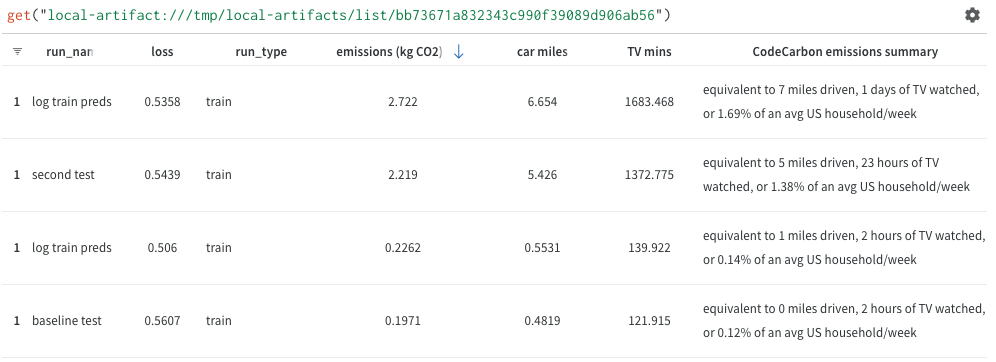

In [33]:
project = "climate_bert"
full_path = "stacey/" + project
runs = get_runs(project)
t = parse_climatebert_runs(runs, full_path)
st = weave.save(t)
st

wandb: Network error (ConnectionError), entering retry loop.


### 3.1 Mendeleev

With more data, we might see that as we increase the size of the fully-connected layer (first column, "fc_size"),
model emissions increase?
* group by "fc_size", sort descending
* standardize bins in emissions column
* optionally rename emissions column
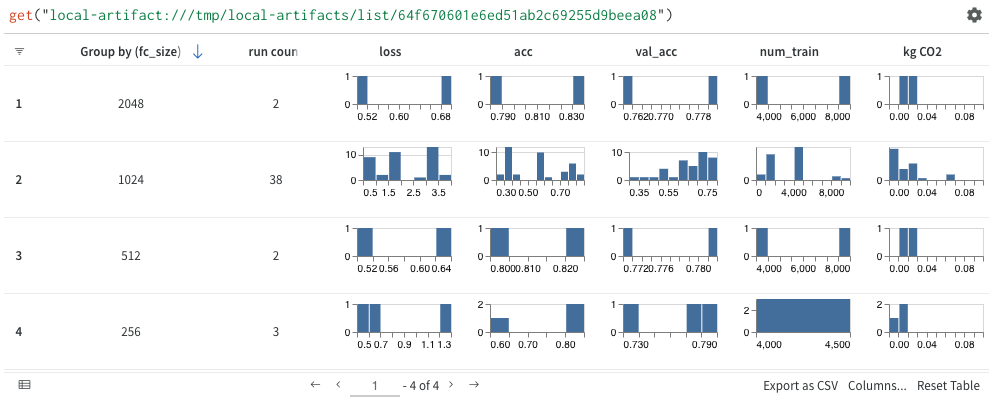

In [34]:
project = "mendeleev"
full_path = "stacey/" + project
runs = get_runs(full_path)
t = parse_mendeleev_runs(runs, full_path)
mt = weave.save(t)
mt

### 3.2 Deep Drive

Resnet34 encoder models might have the lowest emissions, in addition to the best performance??
* group by "encoder", add run count column
* play with histogram columns to get them to convey the distribution difference
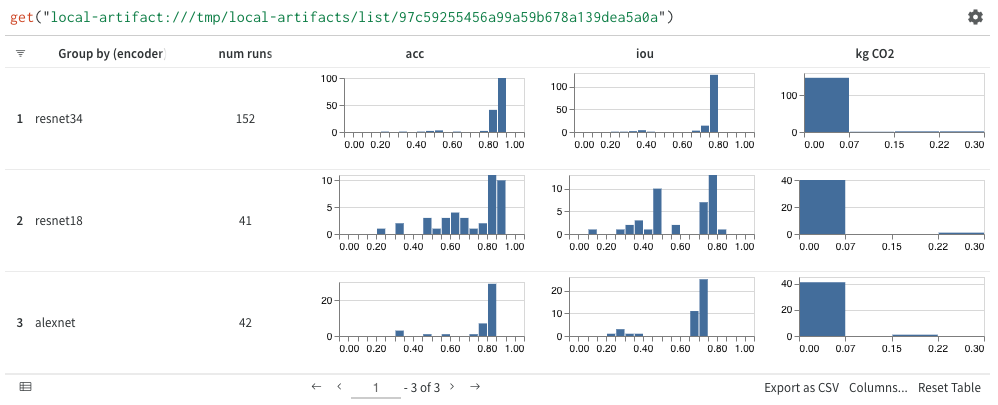

In [ ]:
project = "deep-drive"
full_path = "stacey/" + project
runs = get_runs(project)
t = parse_deepdrive_runs(runs, full_path)
mt = weave.save(t)
mt

another quick example with PanelPlot of the kinds of things we can do :)
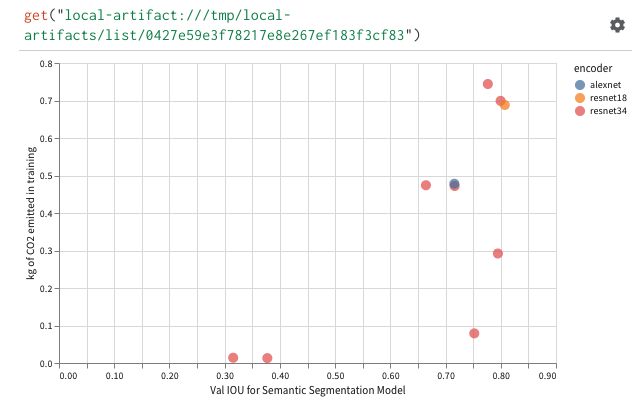

## Appendix: TODOs

* factor out CO2/emissions ops better
* have a story/UX for other geo locations
* write up the different scenarios: GPU past, GPU current, Colab past, Colab current
* factor out into an ecosystem module?
* implement ops for the other scenarios?